# Behavior Models for choice and reaction time prediction

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms
import ssm
from ssm.util import find_permutation
from sklearn import preprocessing

import src.utils.setup_figures as figures
# import src.utils.basic as utils


import numpy.random as npr
npr.seed(0)

### Load Configs

In [3]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)
compiled_dir = Path(dir_config.data.compiled)

### Utils functions

In [4]:
def process_session_data(data):
    data['target'] = (2*data.target - 1).astype(int)
    data['choice'] = data['choice'].astype(int)
    data['signed_coherence'] = data['coherence'] * data['target']
    data['previous_target'] = data.target.shift(1)
    data.loc[data.index[0], 'previous_target'] = data.target.values[0]
    data['previous_choice'] = data.choice.shift(1)
    data.loc[data.index[0], 'previous_choice'] = data.choice.values[0]
    
    first_valid = np.where(data.outcome >= 0)[0][0]
    indices_to_change_previous_choice = data[data.previous_choice == -1].index
        
    for i in indices_to_change_previous_choice:
        if i < first_valid:
            data.loc[data.index[i], 'previous_choice'] = np.random.choice([-1, 1])
            data.loc[data.index[i], 'previous_target'] = np.random.choice([-1, 1])
        else:
            j=0
            while i - j >= 0 and data.at[data.index[i - j], 'previous_choice'] == -1:
                j+=1
            data.loc[data.index[i], 'previous_choice'] = data.loc[data.index[i-j], 'previous_choice']
            data.loc[data.index[i], 'previous_target'] = data.loc[data.index[i-j], 'previous_target']  
    
    
    data['previous_choice'].replace(0, -1, inplace=True) # remap previous choice to -1, 1
    
    
    return data
    

### Load Data

In [5]:
session_metadata = pd.read_csv(compiled_dir / 'sessions_metadata.csv')

aggregate_trial_data = np.array([])
for session in session_metadata.session_id:
    print(session)
    session_data = pd.read_csv(compiled_dir /session/ f'{session}_trial.csv',skipinitialspace=True).fillna(-1)
    # only consider rows with task_type == 1
    data = session_data[session_data.task_type == 1]
    data.reset_index(drop=True, inplace=True)
    
    data = process_session_data(data)
        
    if aggregate_trial_data.size == 0:
        aggregate_trial_data = data
    else:
        aggregate_trial_data = pd.concat([aggregate_trial_data, data])
        
    break

210126_GP_JP


In [6]:
input_all_sessions = []

inputs = np.ones((1, aggregate_trial_data.shape[0], 4))

inputs[0, :, 0] = aggregate_trial_data.signed_coherence.values
inputs[0, :, 1] = aggregate_trial_data.previous_choice.values
inputs[0, :, 2] = aggregate_trial_data.previous_target.values

inputs[0, :, 0] = preprocessing.scale(inputs[0, :, 0])

input_all_sessions = list(inputs)

choices_all_sessions = []
choices_all_sessions.append(aggregate_trial_data.choice.values)
choices_all_sessions[0] = choices_all_sessions[0].reshape(-1, 1)

mask = (aggregate_trial_data.outcome >= 0)
mask = np.array(mask).reshape(-1, 1).tolist()
choices_all_sessions[0][~np.array(mask)]  = np.random.choice([0, 1])



### Prepare data for GLM-HMM

  0%|          | 0/1000 [00:00<?, ?it/s]

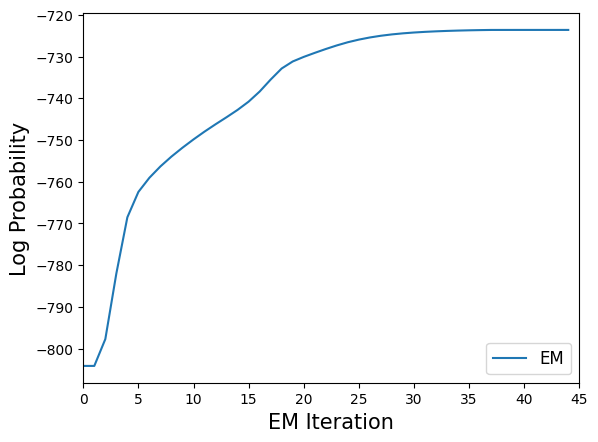

In [124]:
# Set the parameters of the GLM-HMM
num_states = 3          # number of discrete states
obs_dim = 1             # number of observed dimensions
num_categories = 2      # number of categories for output
input_dim = 4           # input dimensions

mask = np.ones(len(choices_all_sessions[0]))
mask[10:1000] = 0

npr.seed(0)
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories), transitions="standard")

fit_ll = glmhmm.fit(choices_all_sessions, inputs=input_all_sessions, mask=mask, method="em", num_iters=1000, tolerance=10**-4)

plt.plot(fit_ll, label="EM")
plt.xlabel("EM Iteration", fontsize=15)
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability", fontsize=15)
plt.legend(loc="lower right", fontsize=12)